# Assignment 5 - Decentralized Hyperparameter Learning

- **Topic:** Decentralized hyperparameter optimization for Gaussian Processes

- **Assessment:** The assignment will go through a pass/fail check.


- **Deadline:** 4.4.2025
- **Submission: SUBMIT ONLY `assignment5_groupNumber.ipynb` TO BRIGHTSPACE**.


## Instructions
**Installation:** The implementation is tested with python 3.10.16 and packages including
-   scipy 1.14.1
-   numpy 1.26.4
-   matplotlib 3.10.0
-   tqdm 4.66.5 (for a progress bar)

Other (not too old) versions will probabily also work.

You may not use other packages for algorithm-related calculations.
You only need to complete (and submit) this file and please do not change other files.

## AI Related Policy
We strongly disencourage you to use AI tools for implementation assistance. It is your understanding of the problem that is tested in the final exam.

## Information
Please fill in your names and student numbers in the cell below.

In [47]:
# YOUR ANSWER HERE
STUDENT_1_NAME = "Niklas Knöll"
STUDENT_1_STUDENT_NUMBER = "5006961"

STUDENT_2_NAME = "Jefferson Yeh"
STUDENT_2_STUDENT_NUMBER = "5296005"

## Objectives
In previous lectures and assignments, you have learnt that the hyperparameters, e.g., signal variance $\sigma_f$ and length scale $l$ in the squared exponential (SE) kernel, can impact the GP regression. As such, it is naturally motivated to learn the hyperparameters from the data instead of tuning them heuristically. This can be modeled as a optimization problem where we maximize the likelihood of the data over the hyperparameters which, as discussed in the lecture, can be computationally inefficient due to the inversion of a large data covariance matrix. In this assignment, instead of implementing a low-rank approximation for complexity reduction, we take a distributed approach, i.e., we distribute the data to multiple agents where we run local (smaller) optimizations with some communications such that the local optimizations converge to a centralized solution. More specifically, you will implement a proximal ADMM (pxADMM) algorithm for the GP hyperparmeter learning problem. If you recall, you have already done such hyperparameter learning in Assignment 3 where you used the a second order solver (BFGS) from scipy. In comparison, you will explicitly implement the solver, the iterative updates, your self in this assignment.

See literature below for more details. 

[1] A. Xie, F. Yin, Y. Xu, B. Ai, T. Chen and S. Cui, "Distributed Gaussian Processes Hyperparameter Optimization for Big Data Using Proximal ADMM," in IEEE Signal Processing Letters, vol. 26, no. 8, pp. 1197-1201, Aug. 2019.

[2] P. Zhai and R. T. Rajan, "Distributed Gaussian Process Hyperparameter Optimization for Multi-Agent Systems," ICASSP 2023 - 2023 IEEE International Conference on Acoustics, Speech and Signal Processing (ICASSP).





## 1. Graph Basics
Here we play with the fundamentals of graph theory. We first load our GP field in which the range of our "playground" is given. Then we generate some random locations for the agent and see if they form a connected graph based on some communication range.

In [48]:
import numpy as np
import copy
import matplotlib.pyplot as plt
import scipy.io as sio
from tqdm import tqdm
from utils import param_array_to_dict, param_dict_to_array, data_generator, visualize_samples_on_field, visualize_sample_allocation, visualize_graphs


# load artificial field data
gp_data = sio.loadmat('artificial_gp_field.mat')
gp_field = gp_data['gp_field'].squeeze()               # true field
field_resolution = gp_data['resolution'].squeeze()     # number of grid point in each dimension
field_range = gp_data['playground_range'].squeeze() 
print("Our Playground Range is: ", field_range)


Our Playground Range is:  [[-5  5]
 [-5  5]]


### 1.1 Adjacency Matrix and Connectivity Check
Here you will implement a function to calculate the adjacency matrix based on a given communication range, i.e., agents within the communications range can have information exchange and thus have a link (edge) in the graph.Then, a function is provided to you to see if a graph is connected. You can tweak the communication range to verify using the graph visulization function.

**Question 1**: What does the adjacency matrix look like if there is a disconnected node?

**Answer**: There is at least one row&column with only zeros except for on the diagonal (the diagonal is always 1)



(2, 15)
[[1 0 0 0 0 1 0 0 0 1 0 0 0 0 0]
 [0 1 1 0 1 0 0 0 0 0 0 1 0 0 0]
 [0 1 1 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 1 0 0 0 1 0 0 0 0 0 1 1]
 [0 1 0 0 1 0 0 0 1 1 0 1 0 0 0]
 [1 0 0 0 0 1 0 0 0 1 0 0 0 0 0]
 [0 0 0 0 0 0 1 0 0 0 1 0 1 0 0]
 [0 0 0 1 0 0 0 1 0 0 0 0 0 1 0]
 [0 0 0 0 1 0 0 0 1 1 0 1 0 0 0]
 [1 0 0 0 1 1 0 0 1 1 0 1 0 0 0]
 [0 0 0 0 0 0 1 0 0 0 1 0 1 0 0]
 [0 1 0 0 1 0 0 0 1 1 0 1 0 0 0]
 [0 0 0 0 0 0 1 0 0 0 1 0 1 0 0]
 [0 0 0 1 0 0 0 1 0 0 0 0 0 1 1]
 [0 0 0 1 0 0 0 0 0 0 0 0 0 1 1]]


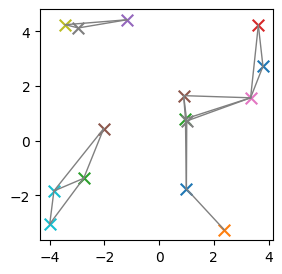

In [49]:
def calculate_adjacency_matrix(agent_locations, communication_range):
    # agent_locations: [GP_INPUT_DIM, NUM_AGENTS]
    # communication_range: float

    num_agents = agent_locations.shape[1]
    adjacency_matrix = np.zeros((num_agents, num_agents), dtype=int)

    ################# YOUR CODE HERE #################
    # only filling in lower triangle
    for i in range(num_agents):
        point_1 = agent_locations[:,num_agents-i-1]
        for j in range(num_agents-i):
            point_2 = agent_locations[:,j]
            adjacency_matrix[num_agents-1-i,j] = 1 if np.linalg.norm(point_1-point_2) < communication_range else 0
    
    # because it is symmetric across the diagonal, we bring the lower triangle to the upper
    adjacency_matrix = adjacency_matrix + adjacency_matrix.T - np.diag(np.diag(adjacency_matrix))
    ##################################################

    return adjacency_matrix

def is_graph_connected(adjacency_matrix):

    degree_matrix = np.diag(np.sum(adjacency_matrix, axis=1))
    laplacian_matrix = degree_matrix - adjacency_matrix

    # Compute eigenvalues of the Laplacian matrix
    eigenvalues = np.linalg.eigvalsh(laplacian_matrix)

    # Count zero eigenvalues
    zero_eigenvalues = np.sum(np.isclose(eigenvalues, 0))

    # Graph is connected if there is exactly one zero eigenvalue
    return zero_eigenvalues == 1
    

NUM_AGENTS = 15
AGENT_COMM_RANGE = 3

# generate agent positions [GP_INPUT_DIM, NUM_AGENTS]
agent_locations = np.array([0.9*np.random.uniform(field_range[0,0], field_range[0,1], NUM_AGENTS),
                            0.9*np.random.uniform(field_range[1,0], field_range[1,1], NUM_AGENTS)])

print(agent_locations.shape)

adjacency_matrix = calculate_adjacency_matrix(agent_locations, AGENT_COMM_RANGE)
print(adjacency_matrix)
if not is_graph_connected(adjacency_matrix):
    print("Warning: The graph is not connected.")
else:
    print("The graph is connected.")
visualize_graphs(agent_locations, adjacency_matrix)

### 1.2 Architecture for Decentralized Optimization

You have seen from the lecture that the (px)ADMM algorithm requires that all nodes are commonly connected to one data fusion node where the local information is collected and processed, which is known as a decentralized architecture.

**Question 2**: what can you say about the adjacency matrix in this case and what are the concerns about this architecture.

**Answer**: The adjacency matrix has to have a row&column consisting entirely of ones for the corresponding nodes to be connected to all other nodes. If that is not the case the algorithm cannot work.

A variation of the decentralized the architecture is the fully distributed version where there is no fusion node and consensus is reached on the edges. In this assignment, we implement the decentralized architecture and we further assume there is an (invisible) fusion node that is already connected to all agents so we do not have to worry about the connectivity of the underlying graph.

## 2. Proximal ADMM

Now we are going to build our pxADMM algorithm step by step. For debugging purposes, you are recommended to use a small scale setup such as `NUM_AGENTS` = 2 and `NUM_SAMPLES_PER_AGENT` = 100. **Warning**: Larger dataset could take significantly longer and please have the toy version working first. Later you could test the performance of the algorithm given massive data.

### 2.1 Simulation Setups



In [50]:
GP_INPUT_DIM = 2
NUM_GP_HYPERPARAMS = 4
STOP_TOLERANCE = 1e-4     # stopping criterion
MAX_ITR = 15000

# measurement noise
noise_std = np.sqrt(0.1)      # noise standard deviation

# the true hyperparameters given in the field data
# the hyperparameters are stored in a dictionary including
gp_hyperparams_true = {
    'signal_var': float(gp_data['sigma_f'].item()),         # sigma_f
    'length_scale': gp_data['l'].squeeze().astype(float),   # l 
    'noise_std': float(noise_std)                       
}

### 2.2 Generate Measurements

Here you will uniformly generate sample locations in the given field range. The `data_generator()` function will give you clean samples at the generated locations. Then you will generate noisy sample using the given noise variance noise_std. The noisy samples together with the sample locations will be divided among the agents. In this assignment, we randomly allocate the same amount of samples to the agents. In more realistic settings, you could also give samples to the agents based on proximity. In the two figures below you will see a contour plot of the given GP field with your samples (the color of the samples should match the background) and the allocation of the samples. 

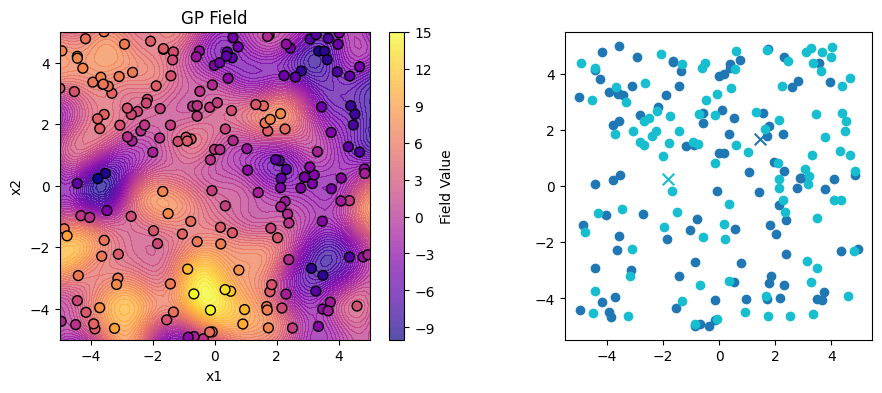

In [51]:
NUM_AGENTS = 2
NUM_SAMPLES_PER_AGENT = 100


def generate_data(gp_field, field_range, field_resolution, num_agents, num_samples_per_agent, noise_std):

    # generate samples locations [GP_INPUT_DIM, TOTAL_NUM_SAMPLES]
    total_num_samples = num_agents * num_samples_per_agent
    ################# YOUR CODE HERE #################
    sample_locations = np.array([np.random.uniform(field_range[0,0], field_range[0,1], total_num_samples),
                                 np.random.uniform(field_range[1,0], field_range[1,1], total_num_samples)])
    ##################################################

    clean_samples, mesh_x1, mesh_x2 = data_generator(sample_locations, gp_field, field_range, field_resolution)

    # generate noisy samples
    ################# YOUR CODE HERE #################
    sample_noise = np.random.normal(scale=noise_std, size=clean_samples.shape)
    noisy_samples = clean_samples + sample_noise
    ##################################################

    # uniformly allocated samples to agents
    noisy_samples_reshaped = np.reshape(noisy_samples, (num_samples_per_agent,num_agents), order = 'C')
    # clean_samples_reshaped = np.reshape(clean_samples, (num_samples_per_agent,num_agents), order = 'C')
    sample_locations_reshaped = np.reshape(sample_locations, (GP_INPUT_DIM, num_samples_per_agent,num_agents), order = 'C')

    sample_locations_list = np.split(sample_locations_reshaped, sample_locations_reshaped.shape[2], axis=2)
    sample_locations_list = [arr.squeeze(axis=2) for arr in sample_locations_list]
    
    return sample_locations_reshaped, sample_locations_list, noisy_samples_reshaped, sample_locations, clean_samples, mesh_x1, mesh_x2


# generate agent positions [GP_INPUT_DIM, NUM_AGENTS]
agent_locations = np.array([0.9*np.random.uniform(field_range[0,0], field_range[0,1], NUM_AGENTS),
                            0.9*np.random.uniform(field_range[1,0], field_range[1,1], NUM_AGENTS)])
sample_locations_reshaped, sample_locations_list, noisy_samples_reshaped, sample_locations, clean_samples, mesh_x1, mesh_x2 = generate_data(gp_field, field_range, field_resolution, NUM_AGENTS, NUM_SAMPLES_PER_AGENT, noise_std)
# visualize the field and samples
fig, axs = plt.subplots(1, 2, figsize=(11, 4))
contour = visualize_samples_on_field(axs[0], mesh_x1, mesh_x2, gp_field, sample_locations, clean_samples)
fig.colorbar(contour, ax=axs[0], label="Field Value")
visualize_sample_allocation(axs[1], agent_locations, sample_locations_list, adjacency_matrix)
plt.show()

### 2.3 Local Computations

Here we establish the agent class where the most crucial local updates happens. We first review the pxADMM algorithm and then we proceed to the code implementation.

As mentioned, the GP hyperparameter optimiziation can be formulated as a likelihood maximiation. Equivalently, we minimize the negative log-likelihood (NLL) and in the context of ADMM, we minimize the sum of the local NLLs subject to consensus contraints:
$$
\begin{align}
  & \underset{\{\boldsymbol{\theta}_n\}_{n=1}^N,\mathbf{z}}{\textrm{min}}
  & & \sum_{n=1}^{N} l_n(\boldsymbol{\theta}_n) \\
  & \text{subject to}
  && \boldsymbol{\theta}_n = \mathbf{z},\quad n=1,...,N\\
\end{align}
$$
where $n=1,...,N$ is the agent index, $\boldsymbol{\theta} = [\sigma_f, l_1, l_2, \sigma_\epsilon]$ are our GP hyperparameters. The local NLL has the form of
$$
l_n(\boldsymbol{\theta}) = \frac{1}{2}\left(\mathbf{y}_n^{\mathsf{T}}\mathbf{K}_n^{-1}(\boldsymbol{\theta})\mathbf{y}_n + \textrm{log}\left| \mathbf{K}_n(\boldsymbol{\theta})  \right|\right)
$$
in which the kernel matrix $\mathbf{K}_n$ consists of the SE kernel values plus the noise variance, i.e.,
$$
k(\mathbf{x}_i,\mathbf{x}_j) = \sigma_f^2\textrm{exp}\left[ -\frac{1}{2}(\mathbf{x}_i-\mathbf{x}_j)^{\mathsf{T}}\boldsymbol{\Sigma}^{-1}(\mathbf{x}_i-\mathbf{x}_j)   \right] + \sigma_\epsilon^2\delta(\mathbf{x}_i-\mathbf{x}_j)
$$
where $\boldsymbol{\Sigma} = \textrm{diag}(l_1^2,l_2^2)$. Note that in this case we use a different length-scale for different GP input dimension, which is a more general case.

Then we could perform the standard ADMM updates from the augmented Lagrangian:
$$
    \mathcal{L}\left( \boldsymbol{\theta}_1,...,\boldsymbol{\theta}_N, \mathbf{z}, \boldsymbol{\lambda}_1,..., \boldsymbol{\lambda}_N\right) = \sum_{n=1}^{N}\left( l_n(\boldsymbol{\theta}_n)+ \boldsymbol{\lambda}_n^{\mathsf{T}}(\boldsymbol{\theta}_n-\mathbf{z}) + \frac{\rho}{2}\left\| \boldsymbol{\theta}_n-\mathbf{z}\right\|_2^2\right)
$$
where $\rho$ is a positive constant and $\boldsymbol{\lambda}_1,..., \boldsymbol{\lambda}_N$ are the dual variables.

The ADMM update equations (z-update, primal update, and dual update) are:
$$
\begin{align}
\mathbf{z}^{t+1} &= \underset{\mathbf{z}}{\textrm{argmin}} \left( \sum_{n=1}^{N}-{\boldsymbol{\lambda}^t_n}^{\mathsf{T}}\mathbf{z} + \frac{\rho}{2}\left\| \boldsymbol{\theta}^t_n-\mathbf{z}\right\|_2^2\right)\\
\boldsymbol{\theta}_n^{t+1} & = \underset{\boldsymbol{\theta}_n}{\textrm{argmin}} \left(  l_n(\boldsymbol{\theta}_n)+ {\boldsymbol{\lambda}^t_n}^{\mathsf{T}}\boldsymbol{\theta}_n + \frac{\rho}{2}\left\| \boldsymbol{\theta}_n-\mathbf{z}^{t+1}\right\|_2^2\right)\\
\boldsymbol{\lambda}_n^{t+1} &= \boldsymbol{\lambda}_n^{t} + \rho(\boldsymbol{\theta}_n^{t+1}-\mathbf{z}^{t+1})
\end{align}
$$

**Question 3**: What is the solution to the z-update?

**Answer**:  
$$
    z^{t+1} = \frac{1}{N} \sum^{N}_{n=1} \left( \frac{1}{\rho} \lambda_n + \theta_n \right)
$$



The primal update contains the NLL and a analytical update is difficult to find. As such, we linearize the NLL using the Taylor expansion
$$
    l_n(\boldsymbol{\theta}_n) \approx l_n(\mathbf{z}^{t+1}) + \nabla^{\mathsf{T}} l_n(\mathbf{z}^{t+1})(\boldsymbol{\theta}_n-\mathbf{z}^{t+1})
$$
such that the primal update becomes
$$
\boldsymbol{\theta}_n^{t+1}  = \underset{\boldsymbol{\theta}_n}{\textrm{argmin}} \left(  l_n(\mathbf{z}^{t+1}) + \nabla^{\mathsf{T}} l_n(\mathbf{z}^{t+1})(\boldsymbol{\theta}_n-\mathbf{z}^{t+1})+ {\boldsymbol{\lambda}^t_n}^{\mathsf{T}}\boldsymbol{\theta}_n + \frac{\rho+L}{2}\left\| \boldsymbol{\theta}_n-\mathbf{z}^{t+1}\right\|_2^2\right)
$$
where there is an additional quadratic term $\frac{L}{2}\left\| \boldsymbol{\theta}_n-\mathbf{z}^{t+1}\right\|_2^2$ to increase stability and $L$ is a constant.

**Question 4**: Give the solution to the above proximal primal update: (hint: many terms are w.r.t $\mathbf{z}^{t+1}$ and does not impact your optimial $\boldsymbol{\theta}_n$

**Answer**:
$$
    \theta^{t+1}_n = z^{t+1} - \frac{1}{\rho + L} \left( \nabla l_n(z^{t+1}) + \lambda_n^t \right)
$$


As you noticed, the term $\nabla l_n(\mathbf{z}^{t+1})$ arises which makes the computation of the gradients necessary, but you don't have to implement this your self. Now let's resume the coding.

In [52]:
class Agent:
    def __init__(self, agent_id, position, noisy_samples, sample_locations, sample_size, gp_input_dim = 2):
        self.id = agent_id
        self.position = position
        self.input_dim = gp_input_dim

        # dataset
        self.noisy_samples_local = noisy_samples
        self.sample_locations_local = sample_locations
        self.sample_size = sample_size
        assert(noisy_samples.shape[0] == sample_size)

    def initialize_pxADMM(self):
        
        self.gp_hyperparams_local = {
                                        'signal_var': 1.,
                                        'length_scale': np.array([2., 2.]),
                                        'noise_std': 1.
                                    }
        self.objective_local = 0

        num_hyperparams = len(param_dict_to_array(self.gp_hyperparams_local))
        self.pxADMM_params = {
                            'dual_var': np.ones(num_hyperparams),       # dual variable
                            'rho': 400,                             # weighting parameter
                            'L': 4000,                              # Lipschitz constant
                        }

    def pxADMM_local_update(self):
        
        # compute gradients
        gradients, self.objective_local = self.compute_gradient()

        # update hyperparameters
        ################# YOUR CODE HERE #################
        z = param_dict_to_array(self.gp_hyperparams_local)
        grad = np.array([gradients['partial_signal_var'], gradients['partial_l'][0], gradients['partial_l'][1], gradients['partial_noise_std']])

        new_theta = z - (1/(self.pxADMM_params['rho'] + self.pxADMM_params['L'])) * (grad + np.array(self.pxADMM_params['dual_var']))

        new_signal_var = new_theta[0]
        new_l = new_theta[1:3]
        new_noise_std = new_theta[3]

        ##################################################
        

        # keep an old copy of the hyperparameters before updating
        old_gp_hyperparams = copy.deepcopy(self.gp_hyperparams_local)
        self.gp_hyperparams_local['signal_var'] = new_signal_var
        self.gp_hyperparams_local['length_scale'] = new_l
        self.gp_hyperparams_local['noise_std'] = new_noise_std

        # raise NotImplementedError()
        # update the dual variable 
        ################# YOUR CODE HERE #################
        # z = np.array(old_gp_hyperparams['signal_var'] + old_gp_hyperparams['length_scale'] + old_gp_hyperparams['noise_std'])
        z = param_dict_to_array(old_gp_hyperparams)

        self.pxADMM_params['dual_var'] += self.pxADMM_params['rho'] * (new_theta - z)
        ##################################################

    def compute_gradient(self):
        from scipy.linalg import cholesky, inv, det
        from scipy.spatial.distance import cdist

        gradients = {}
        
        # raise NotImplementedError()
        K_n = self.gp_hyperparams_local['noise_std']**2 * np.eye(self.sample_size)

        scaled_sample_locations = np.copy(np.diag(1 / self.gp_hyperparams_local['length_scale'] ) @ self.sample_locations_local)
        squared_distance_mat = cdist(scaled_sample_locations.T, scaled_sample_locations.T, 'sqeuclidean')
        K_s = self.gp_hyperparams_local['signal_var']**2 * np.exp(-0.5 * squared_distance_mat)
        K = K_s + K_n

        K_inv = inv(K+1e-10*np.eye(np.shape(K)[0]))
        constant_1 = K_inv - K_inv @ np.outer(self.noisy_samples_local, self.noisy_samples_local) @ K_inv.T
        objective = self.noisy_samples_local.T @ K_inv @ self.noisy_samples_local + np.log(det(K))

        # gradient with respect to signal_var
        K_div_signal_var= 2 / self.gp_hyperparams_local['signal_var'] * K_s
        partial_signal_var= 0.5 * np.trace(constant_1 @ K_div_signal_var)

        # gradient with respect to length_scale
        partial_length_scale = np.zeros(self.input_dim)
        
        squared_distance_dim_1 = cdist(self.sample_locations_local[[0],:].T, self.sample_locations_local[[0],:].T, 'sqeuclidean')
        squared_distance_dim_2 = cdist(self.sample_locations_local[[1],:].T, self.sample_locations_local[[1],:].T, 'sqeuclidean')

        K_div_l_dim_1 = squared_distance_dim_1 * K_s * self.gp_hyperparams_local['length_scale'][0]**(-3)
        K_div_l_dim_2 = squared_distance_dim_2 * K_s * self.gp_hyperparams_local['length_scale'][1]**(-3)
        
        partial_length_scale[0] = 0.5 * np.trace(constant_1 @ K_div_l_dim_1)
        partial_length_scale[1] = 0.5 * np.trace(constant_1 @ K_div_l_dim_2)

        # gradient with respect to noise_var
        K_div_noise_std = 2 * np.sqrt(K_n)
        partial_noise_std = 0.5 * np.trace(constant_1 @ K_div_noise_std)


        gradients['partial_signal_var'] = partial_signal_var
        gradients['partial_l'] = partial_length_scale
        gradients['partial_noise_std'] = partial_noise_std

        return gradients, objective



### 1.5 Run pxADMM


In [53]:


def pxADMM(agent_locations, noisy_samples_reshaped, sample_locations_reshaped, NUM_SAMPLES_PER_AGENT, NUM_AGENTS, MAX_ITR, STOP_TOLERANCE):

    # create some logs for visualization
    gp_hyperparams_log = {
        'signal_var': [],
        'length_scale': [],
        'noise_std': [],
    }
    objective_log = []      # log the negative log likelihood
    params_update_log = []  # log the parameters update

    # initialize agents
    agents = [Agent(i, agent_locations[:, i], noisy_samples_reshaped[:,i],sample_locations_reshaped[:,:,i],NUM_SAMPLES_PER_AGENT) for i in range(NUM_AGENTS)]

    # initialize hyperparameters and pxADMM
    for agent in agents: agent.initialize_pxADMM()
    print('true hyperparameters:', gp_hyperparams_true, 'initialized at:', agents[0].gp_hyperparams_local)
    print('pxADMM settings:', agents[0].pxADMM_params)


    itr = 0
    is_converged = False
    old_gp_hyperparams_global = param_dict_to_array(copy.deepcopy(agents[0].gp_hyperparams_local))


    with tqdm(total=MAX_ITR) as pbar:

        while itr < MAX_ITR and not is_converged:
            itr += 1

            # data fusion, central node, z-update
            gp_hyperparams_global = np.zeros(NUM_GP_HYPERPARAMS)

            ################# YOUR CODE HERE #################
            sum_theta_plus_dual = np.zeros(NUM_GP_HYPERPARAMS)
            for agent in agents:
                theta_i = param_dict_to_array(agent.gp_hyperparams_local)                  # local hyperparameters
                lambda_i = np.array(agent.pxADMM_params['dual_var'])                                 # dual variable
                rho = agent.pxADMM_params['rho']
                
                sum_theta_plus_dual += theta_i + (1 / rho) * lambda_i

            gp_hyperparams_global = sum_theta_plus_dual / NUM_AGENTS

            ##################################################
            
            # local update
            for agent in agents:
                agent.gp_hyperparams_local = param_array_to_dict(copy.deepcopy(gp_hyperparams_global))      # distributed fused hyperparameters
                agent.pxADMM_local_update()                                                                 # local update

            # aggregate the objective values, central node
            objective_global = 0
            for agent in agents:
                objective_global += agent.objective_local
            objective_log.append(objective_global)

            # log the global hyperparameters
            gp_hyperparams_log['signal_var'].append(gp_hyperparams_global[0])
            gp_hyperparams_log['length_scale'].append(gp_hyperparams_global[1:3])
            gp_hyperparams_log['noise_std'].append(gp_hyperparams_global[3])

            # check convergence
            param_diff = np.linalg.norm(gp_hyperparams_global - old_gp_hyperparams_global)

            params_update_log.append(param_diff)
        
            if param_diff < STOP_TOLERANCE:
                is_converged = True
            
            old_gp_hyperparams_global = copy.deepcopy(gp_hyperparams_global)

            pbar.update(1)
            pbar.set_postfix({"params updated by": param_diff})

    if is_converged:
        print('Converged after', itr, 'iterations')
    else:
        print('Not converged after', MAX_ITR, 'iterations')

    print('Final hyperparameters:', param_array_to_dict(gp_hyperparams_global))

    return gp_hyperparams_log, objective_log, params_update_log


gp_hyperparams_log, objective_log, params_update_log = pxADMM(agent_locations, noisy_samples_reshaped, sample_locations_reshaped, NUM_SAMPLES_PER_AGENT, NUM_AGENTS, MAX_ITR, STOP_TOLERANCE)

true hyperparameters: {'signal_var': 5.0, 'length_scale': array([1., 1.]), 'noise_std': 0.31622776601683794} initialized at: {'signal_var': 1.0, 'length_scale': array([2., 2.]), 'noise_std': 1.0}
pxADMM settings: {'dual_var': array([1., 1., 1., 1.]), 'rho': 400, 'L': 4000}


  3%|▎         | 406/15000 [00:21<12:55, 18.83it/s, params updated by=9.88e-5] 

Converged after 406 iterations
Final hyperparameters: {'signal_var': 4.429045772928376, 'length_scale': array([0.9959567 , 0.92728785]), 'noise_std': 0.284544072999552}


### 1.6 Visualize the Results

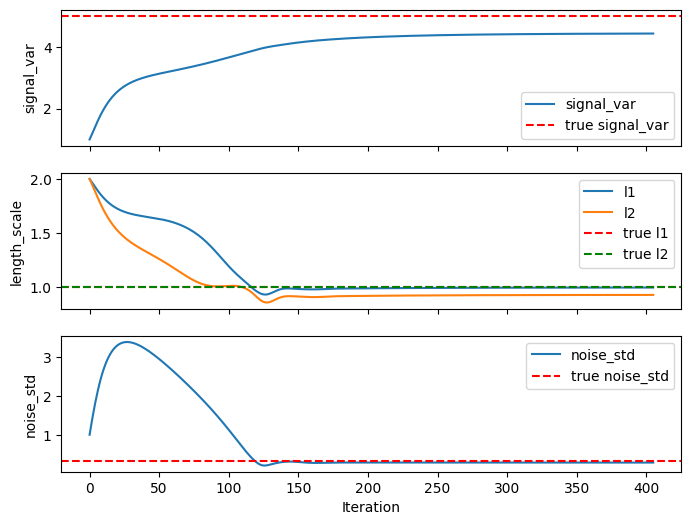

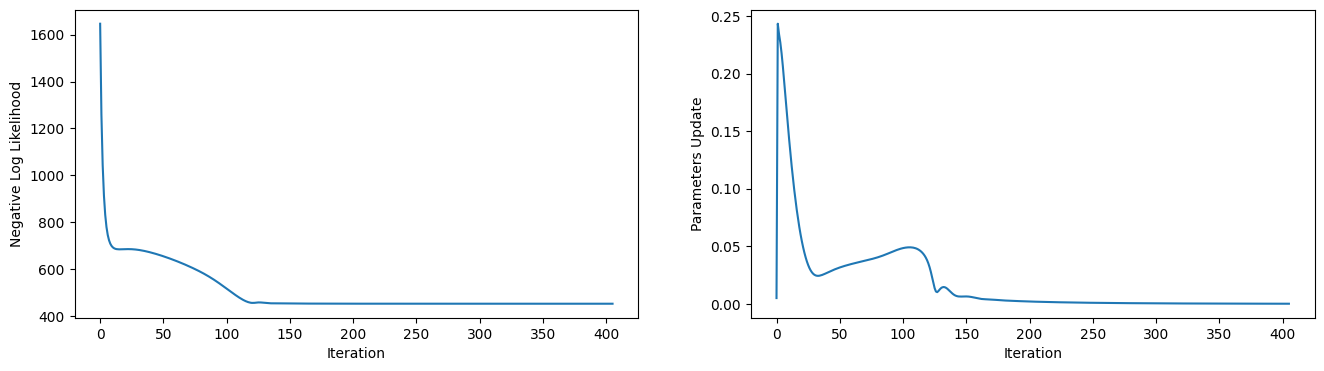

In [54]:
# visualize the convergence of the parameters
fig, axs = plt.subplots(3, 1, figsize=(8, 6), sharex=True)
axs[0].plot(gp_hyperparams_log['signal_var'], label='signal_var')
axs[0].axhline(y=gp_hyperparams_true['signal_var'], color='r', linestyle='--', label='true signal_var')
axs[0].set_ylabel('signal_var')
axs[0].legend()

axs[1].plot([l[0] for l in gp_hyperparams_log['length_scale']], label='l1')
axs[1].plot([l[1] for l in gp_hyperparams_log['length_scale']], label='l2')
axs[1].axhline(y=gp_hyperparams_true['length_scale'][0], color='r', linestyle='--', label='true l1')
axs[1].axhline(y=gp_hyperparams_true['length_scale'][1], color='g', linestyle='--', label='true l2')
axs[1].set_ylabel('length_scale')
axs[1].legend()

axs[2].plot(gp_hyperparams_log['noise_std'], label='noise_std')
axs[2].axhline(y=gp_hyperparams_true['noise_std'], color='r', linestyle='--', label='true noise_std')
axs[2].set_ylabel('noise_std')
axs[2].legend()

plt.xlabel('Iteration')
plt.show()

# visualize the convergence of the objective and the parameters updates
fig, axs = plt.subplots(1, 2, figsize=(16, 4))

axs[0].plot(objective_log)
axs[0].set_xlabel('Iteration')
axs[0].set_ylabel('Negative Log Likelihood')

axs[1].plot(params_update_log)
axs[1].set_xlabel('Iteration')
axs[1].set_ylabel('Parameters Update')

plt.show()

You can see that the pxADMM algorithm converges to the true value but at what are the settings and assumptions we used for the algorithm that do not fully represent the  (hint: you can say something about the algorithm initilization)? 

**Question 6**: Name 2 settings for the above simulation that can be improved.

**Answer**: 

## 3 Algorithm Evaluation (Optional)
You've previously used a toy setup to validate the algorithm and now let's give your computer some stress. Recall that one of the motivations for decentralized learning is the complexity reduction. We keep the sample size the same at 5000 but we vary the number of agents (so the size of the local dataset is different) and see the difference in computation time. Do it a few times and see the trend.

**Question 6a**: From the printed information, how do the number of iterations change when you vary the number of agents? Reason why this is the case.

**Question 6b**: From the printed informtaion, how do the computation time change for each iteration when you vary the number of agents? Reason why this is the case.

**Question 6c**: From the plot, what is the trend of the overal computation time when you vary the number of the agents? And explain Why?

**Answer**: 

In [55]:
import time

num_agent_list = [20, 50, 100, 150, 200]
comutation_time_list = []

for NUM_AGENTS in num_agent_list:

    NUM_SAMPLES_PER_AGENT = 5000 // NUM_AGENTS

    sample_locations_reshaped, sample_locations_list, noisy_samples_reshaped, sample_locations, clean_samples, mesh_x1, mesh_x2 =  generate_data(gp_field, field_range, field_resolution, NUM_AGENTS, NUM_SAMPLES_PER_AGENT, noise_std)

    start_time = time.time()
    gp_hyperparams_log, objective_log, params_update_log = pxADMM(np.random.rand(GP_INPUT_DIM, NUM_AGENTS), noisy_samples_reshaped, sample_locations_reshaped, NUM_SAMPLES_PER_AGENT, NUM_AGENTS, MAX_ITR, STOP_TOLERANCE)
    end_time = time.time()

    comutation_time_list.append(end_time - start_time)
    print(f"Time elapsed for NUM_AGENTS={NUM_AGENTS}: {end_time - start_time:.4f} seconds")

plt.figure()
plt.plot(comutation_time_list, 'o-')
plt.xlabel('Number of Agents')
plt.xticks(range(len(num_agent_list)), num_agent_list)
plt.ylabel('Time elapsed (s)')
plt.show()
    


true hyperparameters: {'signal_var': 5.0, 'length_scale': array([1., 1.]), 'noise_std': 0.31622776601683794} initialized at: {'signal_var': 1.0, 'length_scale': array([2., 2.]), 'noise_std': 1.0}
pxADMM settings: {'dual_var': array([1., 1., 1., 1.]), 'rho': 400, 'L': 4000}


  0%|          | 26/15000 [02:28<23:46:52,  5.72s/it, params updated by=0.0864]


KeyboardInterrupt: 

**Feedback**:
Your feedback will be invaluable in improving it for the coming years. Please let us know in this markdown any comments, suggestions or errors you have encountered for this assignment.